# 2. 短命作品の学習と予測

　目次情報を学習して，短命作品を予測してみます．

## 環境構築

```bash
conda env create -f env.yml
```

## 目次データ

　[0_obtain_comic_data_j.ipynb](0_obtain_comic_data_j.ipynb)で取得した`data/wj-api.json`を使います．また，[1_analyze_comic_data_j.ipynb](1_analyze_comic_data_j.ipynb)で定義した`ComicAnalyzer`を`comic.py`からimportして使います．

In [1]:
import comic

wj = comic.ComicAnalyzer()

## モデル

　何週目までの掲載順を用いるのが適当かわからないので，本記事では，入力の異なる合計7種類の[多層パーセプトロン](https://en.wikipedia.org/wiki/Multilayer_perceptron)を実装します．多層パーセプトロンついては，[誤差逆伝播法のノート](http://qiita.com/Ugo-Nama/items/04814a13c9ea84978a4c)が詳しいです．

![model1.png](fig/model1.png)
![model2.png](fig/model2.png)
![model7.png](fig/model7.png)

　モデル1は1週目のみ，モデル2は2週目まで，…，モデル7は7週目までの掲載順を入力に用います．稀にですが，1週目に巻頭以外に掲載される作品がありますので，1週目の掲載順も入力に加えます．[CS231n Convolutional Neural Networks for Visual Recognition](https://cs231n.github.io/neural-networks-1/)を参考に，隠れ層は3層にします．簡単のため，各隠れ層のノード数は同じ，と仮定します．隠れ層の活性化関数として，[ReLU](https://ja.wikipedia.org/wiki/%E6%B4%BB%E6%80%A7%E5%8C%96%E9%96%A2%E6%95%B0#ReLU.EF.BC.88.E3.83.A9.E3.83.B3.E3.83.97.E9.96.A2.E6.95.B0.EF.BC.89)を使います．出力層は短命作品である確率を出力し，活性化関数として[Sigmoid](https://ja.wikipedia.org/wiki/%E6%B4%BB%E6%80%A7%E5%8C%96%E9%96%A2%E6%95%B0#.E3.82.B7.E3.82.B0.E3.83.A2.E3.82.A4.E3.83.89.E9.96.A2.E6.95.B0)を使います．学習には，学習率$r$の[Adam](https://arxiv.org/abs/1412.6980)を使います．隠れ層のノード数$n$と学習率$r$は，モデルごとに，[TensorBoard](https://www.tensorflow.org/get_started/summaries_and_tensorboard)で遊びながらチューニングします．
 
 　真面目にやるなら，活性化関数や，変数の初期値分布や，最適化アルゴリズムもハイパーパラメータとしてチューニングするべきだとは思います．今回は簡単のため，隠れ層と学習率のみ調整します．それもかなりざっくりと．

## 実装

　多層パーセプトロンを管理するためのクラス`ComicNet()`を以下に定義します．`ComicNet()`は，各種データ（学習，検証，およびテスト）の生成，多層パーセプトロンの構築，学習，およびテストを実行できます．実装には，[TensorFlow](https://www.tensorflow.org/)を用います．[TensorFlow](https://www.tensorflow.org/)については，[特にプログラマーでもデータサイエンティストでもないけど、Tensorflowを1ヶ月触ったので超分かりやすく解説](http://qiita.com/tawago/items/c977c79b76c5979874e8)が詳しいです．

In [10]:
import numpy as np
import tensorflow as tf

class ComicNet():
    """ マンガ作品が短命か否かを識別する多層パーセプトロンを管理するクラスです．
    
    - analyzer：ComicAnalyzerクラスのオブジェクト．
    - thresh_week：短命作品とそれ以外を分けるしきい値．
    - model：多層パーセプトロンに入力する掲載週の数．入力層のノード数．
    - batch_size：学習データのバッチサイズ．検証データのサイズ．
    """
    def __init__(self, analyzer, thresh_week=10, model=6, batch_size=128):
        self.n_x = model
        self.batch_size = batch_size
        self.x_test, self.y_test = self.get_xs_ys(
            analyzer, analyzer.end_titles[-100:],
            thresh_week)
        self.x_val, self.y_val = self.get_xs_ys(
            analyzer, analyzer.end_titles[- 100 - batch_size:-100],
            thresh_week)
        self.x_tra, self.y_tra = self.get_xs_ys(
            analyzer, analyzer.end_titles[:- 100 - batch_size],
            thresh_week)
    
    
    def get_x(self, analyzer, title):
        """指定された作品の指定週までの正規化掲載順を取得する関数です．"""
        worsts = np.array(analyzer.extract_item(title)[:self.n_x])
        bests = np.array(analyzer.extract_item(title, 'best')[:self.n_x])
        bests_normalized = bests / (worsts + bests - 1)    
        return bests_normalized

    
    def get_y(self, analyzer, title, thresh_week=10):
        """指定された作品が，短命作品か否かを取得する関数です．"""
        return float(len(analyzer.extract_item(title)) <=  thresh_week)


    def get_xs_ys(self, analyzer, titles, thresh_week=10):
        """指定された作品群の「正規化掲載順」と「短命作品か否か」を取得する関数です．"""
        xs = np.array([self.get_x(analyzer, title) for title in titles])
        ys = np.array([[self.get_y(analyzer, title, thresh_week)] 
                       for title in titles])
        return xs, ys
    
    
    def build_graph(self, r=0.01, n_h=4, stddev=0.05):
        """多層パーセプトロンを構築する関数です．"""
        tf.reset_default_graph()
        
        # 入力層およびターゲット
        n_y = self.y_test.shape[1]
        self.x = tf.placeholder(tf.float32, [None, self.n_x], name='x')
        self.y = tf.placeholder(tf.float32, [None, n_y], name='y')
        
        # 隠れ層
        self.w_h_1 = tf.Variable(
            tf.truncated_normal((self.n_x, n_h), stddev=stddev))
        self.w_h_2 = tf.Variable(
            tf.truncated_normal((n_h, n_h), stddev=stddev))
        self.w_h_3 = tf.Variable(
            tf.truncated_normal((n_h, n_h), stddev=stddev))
        self.b_h_1 = tf.Variable(tf.zeros(n_h))
        self.b_h_2 = tf.Variable(tf.zeros(n_h))
        self.b_h_3 = tf.Variable(tf.zeros(n_h))
        self.logits = tf.add(tf.matmul(self.x, self.w_h_1), self.b_h_1)
        self.logits = tf.nn.relu(self.logits)
        self.logits = tf.add(tf.matmul(self.logits, self.w_h_2), self.b_h_2)
        self.logits = tf.nn.relu(self.logits)
        self.logits = tf.add(tf.matmul(self.logits, self.w_h_3), self.b_h_3)
        self.logits = tf.nn.relu(self.logits)
        tf.summary.histogram('w_h_1', self.w_h_1)
        tf.summary.histogram('w_h_2', self.w_h_2)
        tf.summary.histogram('w_h_3', self.w_h_3)
        tf.summary.histogram('b_h_1', self.b_h_1)
        tf.summary.histogram('b_h_2', self.b_h_2)
        tf.summary.histogram('b_h_3', self.b_h_3)
        
        # 出力層
        self.w_y = tf.Variable(
            tf.truncated_normal((n_h, n_y), stddev=stddev))
        self.b_y = tf.Variable(tf.zeros(n_y))
        self.logits = tf.add(tf.matmul(self.logits, self.w_y), self.b_y)
        self.logits = tf.nn.sigmoid(self.logits, name='logits')
        tf.summary.histogram('w_y', self.w_y)
        tf.summary.histogram('b_y', self.b_y)
        tf.summary.histogram('logits', self.logits)
        
        # コスト関数
        self.loss = tf.nn.l2_loss(self.y - self.logits, name='loss')
        tf.summary.scalar('loss', self.loss)
        
        # 最適化
        self.optimizer = tf.train.AdamOptimizer(r).minimize(self.loss)
        correct_prediction = tf.equal(self.y, tf.round(self.logits))
        self.acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),
            name='acc')
        tf.summary.scalar('acc', self.acc)
        
        self.merged = tf.summary.merge_all()
            
        
    def train(self, print_loss=False, save_log=False, save_model=False,
              epoch=10000, log_dir='./logs/1', log_name='', 
              model_path='./prediction_model'):
        """多層パーセプトロンを訓練し，ログや学習済みモデルを保存する関数です．"""
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer()) # 変数の初期化
            
            # ログ保存用の設定
            log_tra = log_dir + '/train/' + log_name 
            writer_tra = tf.summary.FileWriter(log_tra)
            log_val = log_dir + '/val/' + log_name
            writer_val = tf.summary.FileWriter(log_val)        

            for e in range(epoch):
                # trainingバッチの生成
                index_batch = np.random.choice(
                    np.arange(len(self.x_tra)), self.batch_size, replace=False)
                x_tra_batch = self.x_tra[index_batch]
                y_tra_batch = self.y_tra[index_batch]
                
                # training
                feed_dict = {self.x: x_tra_batch, self.y: y_tra_batch}
                _, loss_tra, acc_tra, mer_tra = sess.run(
                        (self.optimizer, self.loss, self.acc, self.merged), 
                        feed_dict=feed_dict)
                
                # validation
                feed_dict = {self.x: self.x_val, self.y: self.y_val}
                loss_val, acc_val, mer_val = sess.run(
                    (self.loss, self.acc, self.merged),
                    feed_dict=feed_dict)
                
                # ログの保存
                if save_log:
                    writer_tra.add_summary(mer_tra, e)
                    writer_val.add_summary(mer_val, e)
                
                # コスト関数の出力
                if print_loss and e % 500 == 0:
                    print('# epoch {}: loss_tra = {}, loss_val = {}'.
                          format(e, str(loss_tra), str(loss_val)))
            
            # モデルの保存
            if save_model:
                saver = tf.train.Saver()
                _ = saver.save(sess, model_path)
            
            
    def test(self, model_path='./prediction_model'):
        """指定されたモデルを読み込み，テストする関数です．"""
        tf.reset_default_graph()
        loaded_graph = tf.Graph()
        
        with tf.Session(graph=loaded_graph) as sess:
            
            # モデルの読み込み
            loader = tf.train.import_meta_graph(
                model_path + '.meta')
            loader.restore(sess, model_path)
            
            x_loaded = loaded_graph.get_tensor_by_name('x:0')
            y_loaded = loaded_graph.get_tensor_by_name('y:0')
            
            loss_loaded = loaded_graph.get_tensor_by_name('loss:0')
            acc_loaded = loaded_graph.get_tensor_by_name('acc:0')
            logits_loaded = loaded_graph.get_tensor_by_name('logits:0')
        
            # test
            feed_dict = {x_loaded: self.x_test, y_loaded: self.y_test}
            loss_test, acc_test, logits_test = sess.run(
                (loss_loaded, acc_loaded, logits_loaded), feed_dict=feed_dict)
            return acc_test, logits_test

　以下では，簡単に`ComicNet`を解説します．TensorFlowの考え方については，[TensorFlowのキーコンセプト: Opノード、セッション、変数](http://qiita.com/yanosen_jp/items/70e6d6afc36e1c0a3ef3)が詳しいです．

### データの生成：`get_x()`，`get_y()`，`get_xs_ys()`

　`get_x()`は，0から1の間に正規化された掲載順を返します．`get_y()`は，短命作品か（`1`）否か（`0`）を返します．`get_xs_ys()`は，内部で`get_x()`および`get_y()`を呼び出し，複数タイトルの`x`および`y`を返します．
 
　`ComicNet`は初期化時に，trainingデータ（`x_tra`，`y_tra`），validationデータ（`x_val`，`y_val`），およびtestデータ（`x_test`，`y_test`）を生成します．trainingデータは，文字通りモデルの学習に用いるデータです．検証用データは，モデルの汎化性能を一時的に評価するため（trainingデータへの過学習を防ぐため）のデータであり，ハイパーパラメータの調整時に利用します．testデータは，ハイパーパラメータ調整後のモデルの性能を評価するためのデータです．これらについては，[なぜ教師あり学習でバリデーションセットとテストセットを分ける必要があるのか？](http://qiita.com/QUANON/items/ae569961ea02b4468e23)がわかりやすいです．今回は，`wj.end_titles`のうち，最新100件をtestデータ，残りの最新`batch_size`件をvalidationデータ，残りをtrainデータとして用います．

### ネットワークの構築：`build_graph()`

　入力層では，`tf.placeholder`で入力テンソル（`x`）や教師ラベルテンソル（`y`）をを定義します．
 
　隠れ層では，`tf.Variable`で重みテンソル（`w_h_1`，`w_h_2`，`w_h_3`）やバイアス（`b_h_1`，`b_h_2`，`b_h_3`）を定義します．ここでは，`Variable`の初期分布として[`tf.truncated_normal`](https://www.tensorflow.org/api_docs/python/tf/truncated_normal)を与えています．`truncated_normal`は，2シグマより外の値を除外した正規分布であり，好んでよく使われます．実は，この`truncated_normal`の標準偏差は，モデルの性能を左右する重要なハイパーパラメータの一つですが，今回は簡単のため`0.05`に固定します．[`tf.add`](https://www.tensorflow.org/api_docs/python/tf/add)，[`tf.matmul`](https://www.tensorflow.org/api_docs/python/tf/matmul)，[`tf.nn.relu`](https://www.tensorflow.org/api_docs/python/tf/nn/relu)を使って，テンソル同士を結合し，隠れ層を形作っていきます．ちなみに，[`tf.nn.relu`](https://www.tensorflow.org/api_docs/python/tf/nn/relu)を[`tf.nn.sigmoid`](https://www.tensorflow.org/api_docs/python/tf/sigmoid#tfnnsigmoid)に書き換れば，活性化関数として[Sigmoid](https://ja.wikipedia.org/wiki/%E6%B4%BB%E6%80%A7%E5%8C%96%E9%96%A2%E6%95%B0#.E3.82.B7.E3.82.B0.E3.83.A2.E3.82.A4.E3.83.89.E9.96.A2.E6.95.B0)を使うことができます．TensorFlowで使用可能な活性化関数については，[こちら](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn/activation_functions_)をご参照ください．[`tf.summary.histgram`](https://www.tensorflow.org/api_docs/python/tf/summary/histogram)に`tf.Variable`を渡すことで，TensorBoardでヒストグラムを確認できるようになります．
  
　出力層では，基本的に潜れ層と同様の処理を行います．
 
　コスト関数は，[`tf.nn.l2_loss`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn/losses)で定義します．[`tf.summary.scalar`](https://www.tensorflow.org/api_docs/python/tf/summary/scalar)に`tf.Variable`を渡すことで，TensorBoardで時変化を確認できるようになります．
 
　最適化アルゴリズムとして，[`tf.train.AdamOptimizer`](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer)を使います．TensorFlowで使用可能な最適化アルゴリズムについては，[こちら](https://www.tensorflow.org/versions/r0.12/api_docs/python/train/)をご参照ください．最終的な出力値`logits`を四捨五入し（つまり閾値0.5で判定し），教師ラベル`y`に対する正解率を`acc`として計算しています．最後に，全ての[`tf.summary.merge_all`](https://www.tensorflow.org/api_docs/python/tf/summary/merge_all)で全てのログ情報をマージします．

### 訓練：`train()`

　TensorFlowでは，[`tf.Session`](https://www.tensorflow.org/api_docs/python/tf/Session)中で訓練を行います．必ず，[`tf.global_variables_initializer()`](https://www.tensorflow.org/api_docs/python/tf/global_variables_initializer)で`Variable`の初期化を行う必要があります（これがないと怒られます）．
 
 　`sess.run(self.optimizer)`によって，モデルを訓練します．`sess.run`の第一引数は，タプルによって複数指定することが可能です．また，`sess.run()`時に，辞書形式で`placeholder`に値を代入する必要があります．Training時は`x_tra_batch`と`x_tra_batch`を代入し，Validation時は`x_val`と`y_val`を代入します．

　[`tf.summary.FileWriter`](https://www.tensorflow.org/api_docs/python/tf/summary/FileWriter)で，TensorBoard用のログ情報を保存できます．また，[`tf.train.Saver`](https://www.tensorflow.org/api_docs/python/tf/train/Saver)で訓練後のモデルを保存できます．

### テスト：`test()`

　`test()`は，訓練した多層パーセプトロンをテストするメンバ関数です．[`tf.train.import_meta_graph`](https://www.tensorflow.org/api_docs/python/tf/train/import_meta_graph)を使って，学習済みのモデルを読み込みます．testデータ（`x_test`，`y_test`）を`feed_dict`に与え，`sess.run`します．

## 実験1.  短命作品（10週以内）の予測

　当初の目的である短命作品（10週以内）の予測に挑戦します．

### ハイパーパラメータの調整
　[TensorBoard](https://www.tensorflow.org/get_started/summaries_and_tensorboard)を使ってハイパーパラメータ（隠れ層のノード数$n$と，学習率$r$）をチューニングします．TensorBoardの詳細は[公式](https://www.tensorflow.org/get_started/summaries_and_tensorboard)をご参照ください．いろいろ遊べますが，本記事では，validationデータの正解率とコスト関数を可視化することで，ハイパーパラメータの調整を行います．

In [40]:
for model in range(1, 8):
    wjnet = ComicNet(wj, model=model)
    for r in [0.1, 0.05, 0.01, 0.005, 0.001]:
        for n in range(1, 8):
            log_dir = './logs/1/model=' + str(model)
            log_name = 'r={},n={}'.format(str(r), str(n))
            wjnet.build_graph(r=r, n_h=n)
            wjnet.train(save_log=True, log_dir=log_dir, log_name=log_name)
            print('Saved log of model={}, r={}, n={}'.\
                  format(str(model), str(r), str(n)))

Saved log of model=1, r=0.1, n=1
Saved log of model=1, r=0.1, n=2
Saved log of model=1, r=0.1, n=3
Saved log of model=1, r=0.1, n=4
Saved log of model=1, r=0.1, n=5
Saved log of model=1, r=0.1, n=6
Saved log of model=1, r=0.1, n=7
Saved log of model=1, r=0.05, n=1
Saved log of model=1, r=0.05, n=2
Saved log of model=1, r=0.05, n=3
Saved log of model=1, r=0.05, n=4
Saved log of model=1, r=0.05, n=5
Saved log of model=1, r=0.05, n=6
Saved log of model=1, r=0.05, n=7
Saved log of model=1, r=0.01, n=1
Saved log of model=1, r=0.01, n=2
Saved log of model=1, r=0.01, n=3
Saved log of model=1, r=0.01, n=4
Saved log of model=1, r=0.01, n=5
Saved log of model=1, r=0.01, n=6
Saved log of model=1, r=0.01, n=7
Saved log of model=1, r=0.005, n=1
Saved log of model=1, r=0.005, n=2
Saved log of model=1, r=0.005, n=3
Saved log of model=1, r=0.005, n=4
Saved log of model=1, r=0.005, n=5
Saved log of model=1, r=0.005, n=6
Saved log of model=1, r=0.005, n=7
Saved log of model=1, r=0.001, n=1
Saved log of 

Saved log of model=7, r=0.001, n=3
Saved log of model=7, r=0.001, n=4
Saved log of model=7, r=0.001, n=5
Saved log of model=7, r=0.001, n=6
Saved log of model=7, r=0.001, n=7


　TensorBoardを起動します．ここでは，`model=7`のvalidation結果を見てみます．
 
```bash
tensorboard --logdir=./logs/1/model=7/val
```

　指定されたURLをブラウザで開きます．

![tensorboard.png](fig/tensorboard.png)

　上図はvalidationデータの正解率（`acc`），下図はvalidationデータのコスト関数（`loss`）を表します．横軸はエポック数を表します．凡例が多すぎてわけがわからないので，左下の`Runs`でフィルタリングします．下図は，`n=7`でフィルタリングした例です．

![scalar,n=7.png](fig/scalar,n=7.png)

　`r=0.001`がいい感じであることがわかります．次は，`r=0.001`でフィルタリングします．

![scalar,r=0.001.png](fig/scalar,r=0.001.png)

　どうやら，`model=7`に関しては，`n=7, r=0.001`が良さそうです．また，`e=5000`あたりからtrainingデータへの過学習が始まり，正解率とコスト関数が悪化していることがなんとなくわかります．そこで，`model=7`に関しては，学習を5000エポックで打ち切ることにします．
 
　上記の作業を，他のモデル（`model=1, 2,..., 6`）に関しても行い，ハイパーパラメータを最適化します．
 
 |model | $r$ | $n$ | epoch |
 |:--|:--|:--|:--|
 |1|0.001|1|5000|
 |2|0.05|3|5000|
 |3|0.001|5|2000|
 |4|0.005|7|5000|
 |5|0.01|7|5000|
 |6|0.001|7|3000|
 |7|0.001|7|5000|

### 学習

　最適化したハイパーパラメータで，再度訓練を行い，モデルを保存します．

In [ ]:
params = [
    [1, 0.001, 1, 5000], [2, 0.05, 3, 5000], [3, 0.001, 5, 2000],
    [4, 0.005, 7, 5000], [5, 0.01, 7, 5000], [6, 0.001, 7, 3000], 
    [7, 0.001, 7, 5000]]
for param in params:
    model = param[0]
    r = param[1]
    n = param[2]
    epoch = param[3]
    model_path = './model{}_thesh10'.format(str(model))
    
    wjnet = ComicNet(wj, model=model)
    wjnet.build_graph(r=r, n_h=n)
    wjnet.train(save_model=True, model_path=model_path, epoch=epoch)
    print('Trained', model_path)

Trained ./model1_thesh10
Trained ./model2_thesh10
Trained ./model3_thesh10


### テスト

### 考察

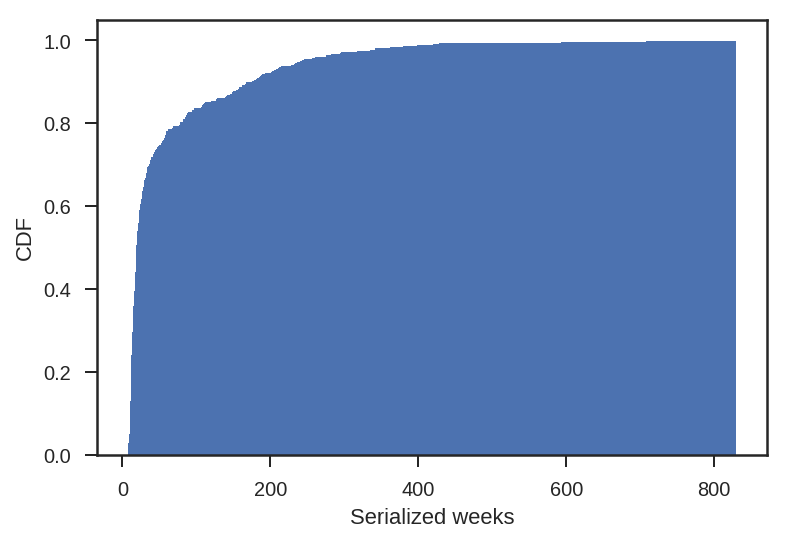

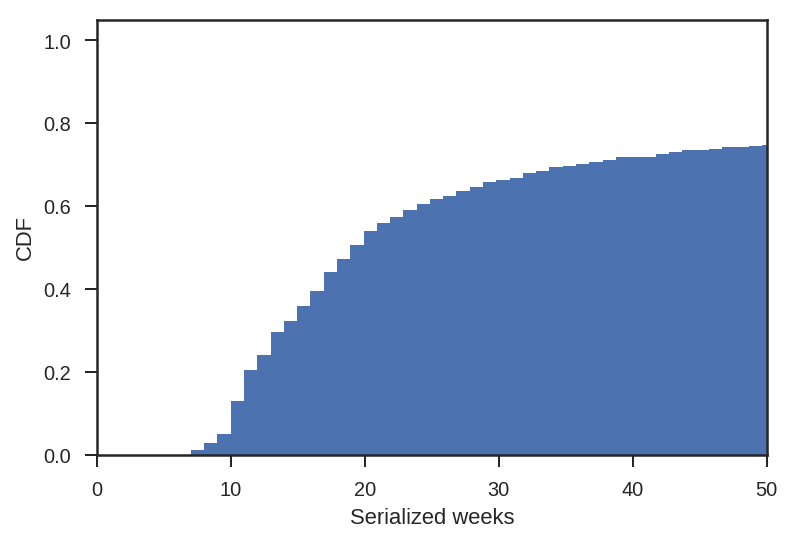

In [37]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt

weeks = [len(wj.extract_item(title))
         for title in wj.end_titles]
plt.figure()
_ = plt.hist(weeks, normed=True, cumulative=True, bins=max(weeks))
plt.xlabel('Serialized weeks')
plt.ylabel('CDF')

plt.figure()
_ = plt.hist(weeks, normed=True, cumulative=True, bins=max(weeks))
plt.xlim(0, 50)
plt.xlabel('Serialized weeks')
plt.ylabel('CDF')

## 実験2. 短命作品（20週以内）の予測

### ハイパーパラメータの調整

In [41]:
for model in range(1, 8):
    wjnet = ComicNet(wj, model=model, thresh_week=20)
    for r in [0.1, 0.05, 0.01, 0.005, 0.001]:
        for n in range(1, 8):
            log_dir = './logs/2/model=' + str(model)
            log_name = 'r={},n={}'.format(str(r), str(n))
            wjnet.build_graph(r=r, n_h=n)
            wjnet.train(save_log=True, log_dir=log_dir, log_name=log_name)
            print('Saved log of model={}, r={}, n={}'.\
                  format(str(model), str(r), str(n)))

Saved log of model=1, r=0.1, n=1
Saved log of model=1, r=0.1, n=2
Saved log of model=1, r=0.1, n=3
Saved log of model=1, r=0.1, n=4
Saved log of model=1, r=0.1, n=5
Saved log of model=1, r=0.1, n=6
Saved log of model=1, r=0.1, n=7
Saved log of model=1, r=0.05, n=1
Saved log of model=1, r=0.05, n=2
Saved log of model=1, r=0.05, n=3
Saved log of model=1, r=0.05, n=4
Saved log of model=1, r=0.05, n=5
Saved log of model=1, r=0.05, n=6
Saved log of model=1, r=0.05, n=7
Saved log of model=1, r=0.01, n=1
Saved log of model=1, r=0.01, n=2
Saved log of model=1, r=0.01, n=3
Saved log of model=1, r=0.01, n=4
Saved log of model=1, r=0.01, n=5
Saved log of model=1, r=0.01, n=6
Saved log of model=1, r=0.01, n=7
Saved log of model=1, r=0.005, n=1
Saved log of model=1, r=0.005, n=2
Saved log of model=1, r=0.005, n=3
Saved log of model=1, r=0.005, n=4
Saved log of model=1, r=0.005, n=5
Saved log of model=1, r=0.005, n=6
Saved log of model=1, r=0.005, n=7
Saved log of model=1, r=0.001, n=1
Saved log of 

Saved log of model=7, r=0.001, n=3
Saved log of model=7, r=0.001, n=4
Saved log of model=7, r=0.001, n=5
Saved log of model=7, r=0.001, n=6
Saved log of model=7, r=0.001, n=7


### 学習

### テスト

### 考察

## 実験3. 架空のマンガ作品の打切予測

## タスク（2017/5/21）

* `ComicNet()`のメンバ関数に，データ生成用の関数も含めること．`ComicNet()`には，何も考えずにComicAnalizer()`の結果を突っ込めるようにしたい．
* `ComicNet()`の引数に，`threash_week`を追加すること．
* `ComicNet()`の引数に，`save`を追加すること．これは，学習結果を保存するか否かを表すフラグ．
* 最終的には，10週終了，20週終了，30週終了の予測結果をまとめてひとつのグラフにすること．
* 考察では，大きく外れた例を一つか２つ掲載すること．
* `ComicEndPredictor()`というクラスを生成すること．これは，学習済みデータをそのまま使って，終了予測を行うことができるクラス．つまり，githubには学習済みクラスのsavarデータをアップする必要がある．